## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv(r'C:\Users\user\Desktop\Машинное обучение\lab3\data.csv')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
# место для кода

In [6]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [7]:
data.dropna(subset=['Age']).reset_index(drop=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

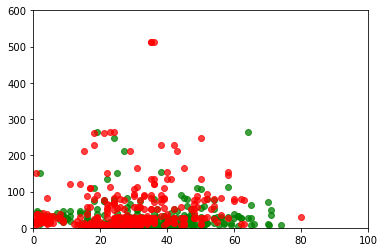

In [16]:
isGood = data['Survived']==0
isBad = data['Survived']==1

x1 = data.loc[isGood, 'Age']
y1 = data.loc[isGood, 'Fare']

x2 = data.loc[isBad, 'Age']
y2 = data.loc[isBad,'Fare']

fig,ax = plt.subplots()

plt.xlim([0, 100])
plt.ylim([0, 600])

ax.scatter(x1, y1, alpha=0.75, color="green")
ax.scatter(x2, y2, alpha=0.75, color="red")
plt.show()

In [ ]:
# место для кода

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [18]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [19]:
import numpy as np
import tqdm

In [20]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [21]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|██████████| 891/891 [25:58<00:00,  1.75s/it]

0.5589225589225589


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [57]:
def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K):
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

In [58]:
# место для кода

In [59]:
# место для кода

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [60]:
idx = np.argsort(calcMargin)

In [61]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

#Комментарий объясняющий данные

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [56]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]

#Комментарий объясняющий данные

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
